# Single Cell Multiomics

Modalities:
- scRNA (Cells x Genes)
- scATAC (Cells x Peaks)

Axes:
- Cells
- Genes
- Peaks

## Install Packages

```bash
# Create environment
conda create -n {YOUR ENVIRONMENT NAME} "conda-forge::python>=3.9,<3.12"
conda activate {YOUR ENVIRONMENT NAME}

# Install GmGM
pip install gmgm

# Install this example notebook's dependencies
pip install scikit-misc
conda install conda-forge::scanpy
conda install conda-forge::muon
conda install conda-forge::leidenalg
```

## Download Data

From [10x Genomics](https://www.10xgenomics.com/resources/datasets/10-k-human-pbm-cs-multiome-v-1-0-chromium-x-1-standard-2-0-0), download the "Filtered feature barcode matrix (HDF5)" from the "10k Human PBMCs, Multiome v1.0, Chromium X" dataset (the one with the ID `10k_PBMC_Multiome_nextgem_Chromium_X`, [linked here](https://www.10xgenomics.com/resources/datasets/10-k-human-pbm-cs-multiome-v-1-0-chromium-x-1-standard-2-0-0)).

## Setup Code

In [1]:
# ============ Parameters ============
# Number of edges to have in our output graphs (GmGM and KNN)
N_EDGES = 10
# Random state for reproducibility
RANDOM_STATE = 0
# Number of principal components to use when using PCA or approximate GmGM
N_COMPONENTS = 20

In [2]:
# Ignore nonsense warnings from scanpy
import warnings
warnings.filterwarnings("ignore", module="scanpy")
warnings.filterwarnings("ignore", module="umap")
warnings.filterwarnings("ignore", module="tqdm")

In [3]:
# Import GmGM
from GmGM import GmGM, Dataset

# `scanpy` is not a dependency of our algorithm, but we will use it for this example
import scanpy as sc
import muon as mu

# Other dependencies, already installed by either GmGM or scanpy
import anndata as ad
import mudata as md
import seaborn as sns
import dask.array as da

## Analyze

In [4]:
mdata: md.MuData = \
    mu.read_10x_h5("./data/10k_PBMC_Multiome_nextgem_Chromium_X_filtered_feature_bc_matrix.h5")
mdata.var_names_make_unique()
mdata

/Users/baileyandrew/mambaforge/envs/GmGM-python-demo/lib/python3.9/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


Added `interval` annotation for features from ./data/10k_PBMC_Multiome_nextgem_Chromium_X_filtered_feature_bc_matrix.h5


/Users/baileyandrew/mambaforge/envs/GmGM-python-demo/lib/python3.9/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/Users/baileyandrew/mambaforge/envs/GmGM-python-demo/lib/python3.9/site-packages/mudata/_core/mudata.py:479: UserWarning: var_names are not unique. To make them unique, call `.var_names_make_unique`.
  warnings.warn(


MuData object with n_obs × n_vars = 10970 × 148344
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	10970 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
    atac:	10970 x 111743
      var:	'gene_ids', 'feature_types', 'genome', 'interval'

In [5]:
sc.pp.log1p(mdata["rna"])
sc.pp.log1p(mdata["atac"])
sc.pp.highly_variable_genes(mdata["rna"])
sc.pp.highly_variable_genes(mdata["atac"])
mdata.update()
mdata

MuData object with n_obs × n_vars = 10970 × 148344
  var:	'gene_ids', 'feature_types', 'genome', 'interval', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
  2 modalities
    rna:	10970 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'log1p', 'hvg'
    atac:	10970 x 111743
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'log1p', 'hvg'

In [6]:
# This dataset is very large so we will limit to highly variable genes and peaks
# This takes about a minute.
GmGM(
    mdata,
    centering_method="avg-overall",
    to_keep={
        "obs": N_EDGES,
        "rna-var": N_EDGES,
        "atac-var": N_EDGES,
    },
    threshold_method="rowwise-col-weighted",
    verbose=True,
    n_comps=N_COMPONENTS,
    use_highly_variable=True
)

/Users/baileyandrew/mambaforge/envs/GmGM-python-demo/lib/python3.9/site-packages/GmGM/dataset.py:163: UserWarning: Trying to set rna's tensor of type <class 'anndata._core.views.SparseCSRView'> to read-only, but this dataset has no `flags` attribute.  Making a copy instead.
  warnings.warn(
/Users/baileyandrew/mambaforge/envs/GmGM-python-demo/lib/python3.9/site-packages/GmGM/dataset.py:163: UserWarning: Trying to set atac's tensor of type <class 'anndata._core.views.SparseCSRView'> to read-only, but this dataset has no `flags` attribute.  Making a copy instead.
  warnings.warn(
/Users/baileyandrew/mambaforge/envs/GmGM-python-demo/lib/python3.9/site-packages/GmGM/core/preprocessing.py:32: UserWarning: Dataset was sparse but `avg-overall` centering will desparsify it, consider using a different centering method.  Converting to dense array...
  warnings.warn(


Centering...
Calculating eigenvectors...
	by calculating left eigenvectors of concatenated matricizations...
Calculating eigenvalues...
@0: 29813812.02726434 (-549.4727356568552 + 29814361.5 + 0) ∆inf
Converged! (@5: 29813812.02726434)
Recomposing sparse precisions...
Converting back to MuData...


/Users/baileyandrew/mambaforge/envs/GmGM-python-demo/lib/python3.9/site-packages/GmGM/dataset.py:597: UserWarning: `use_highly_variable` was set to True but no highly variable indices were provided for axis 'obs'.  Thus we will use all indices for this axis.
  warnings.warn(


MuData object with n_obs × n_vars = 10970 × 148344
  var:	'gene_ids', 'feature_types', 'genome', 'interval', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
  uns:	'obs_neighbors_gmgm'
  obsp:	'obs_gmgm_connectivities'
  2 modalities
    rna:	10970 x 36601
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'log1p', 'hvg', 'rna-var_neighbors_gmgm'
      varp:	'rna-var_gmgm_connectivities'
    atac:	10970 x 111743
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'log1p', 'hvg', 'atac-var_neighbors_gmgm'
      varp:	'atac-var_gmgm_connectivities'

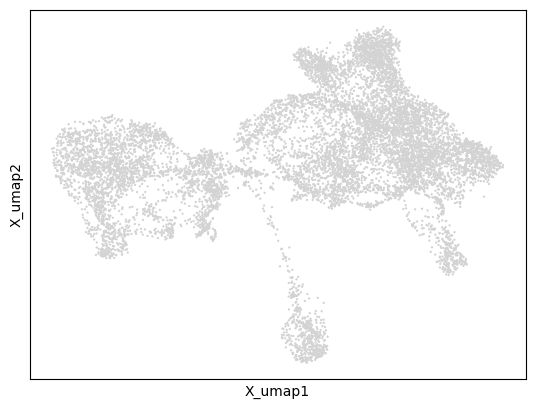

In [7]:
for modality in mdata.mod:
    sc.pp.pca(mdata[modality], n_comps=N_COMPONENTS, random_state=RANDOM_STATE)
    sc.pp.neighbors(mdata[modality], n_neighbors=N_EDGES, random_state=RANDOM_STATE)
mu.pp.neighbors(mdata, n_neighbors=N_EDGES, random_state=RANDOM_STATE)
mu.tl.umap(mdata, random_state=RANDOM_STATE, n_components=3)
mu.pl.umap(mdata)

In [8]:
# Cluster on GmGM
sc.tl.leiden(
    mdata,
    neighbors_key='obs_neighbors_gmgm',
    key_added='leiden_gmgm',
    random_state=RANDOM_STATE
)

# Cluster on KNN
sc.tl.leiden(
    mdata,
    neighbors_key='neighbors',
    key_added='leiden_knn',
    random_state=RANDOM_STATE
)

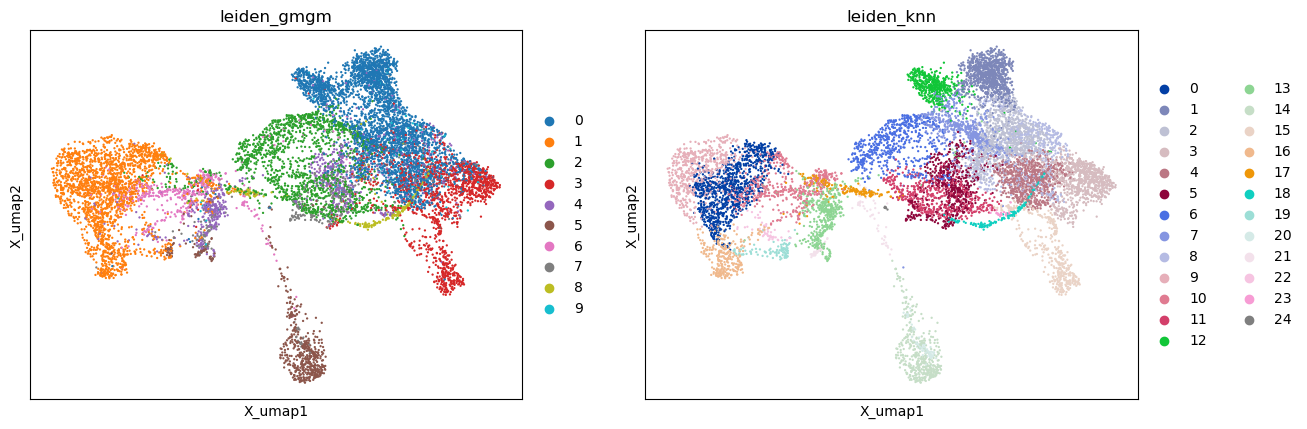

In [9]:
mu.pl.umap(mdata, color=["leiden_gmgm", "leiden_knn"])

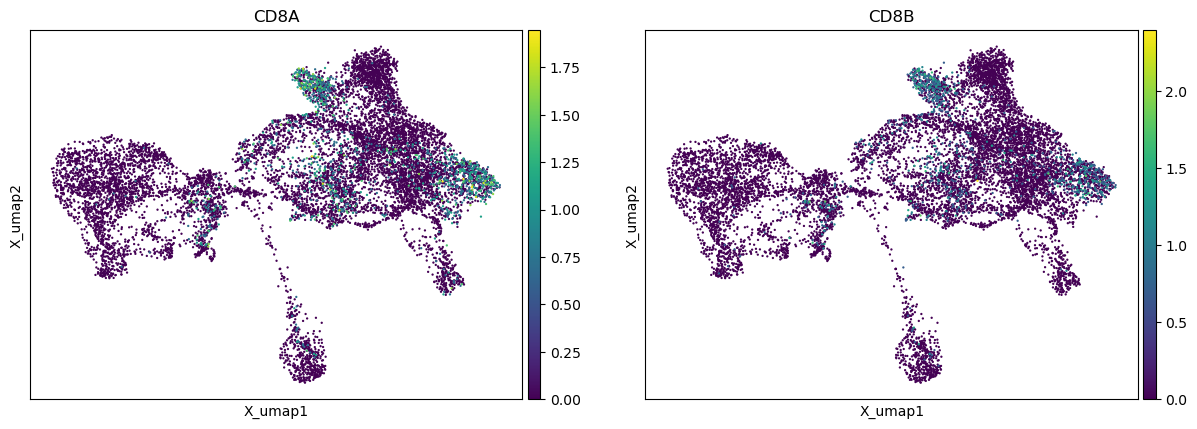

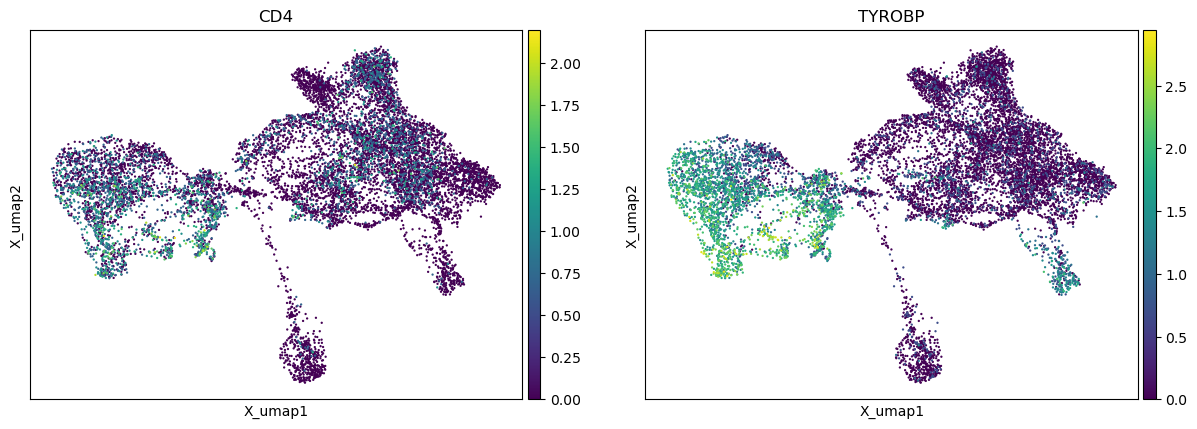

In [10]:
mu.pl.umap(mdata, color=["CD8A", "CD8B"])
mu.pl.umap(mdata, color=["CD4", "TYROBP"])

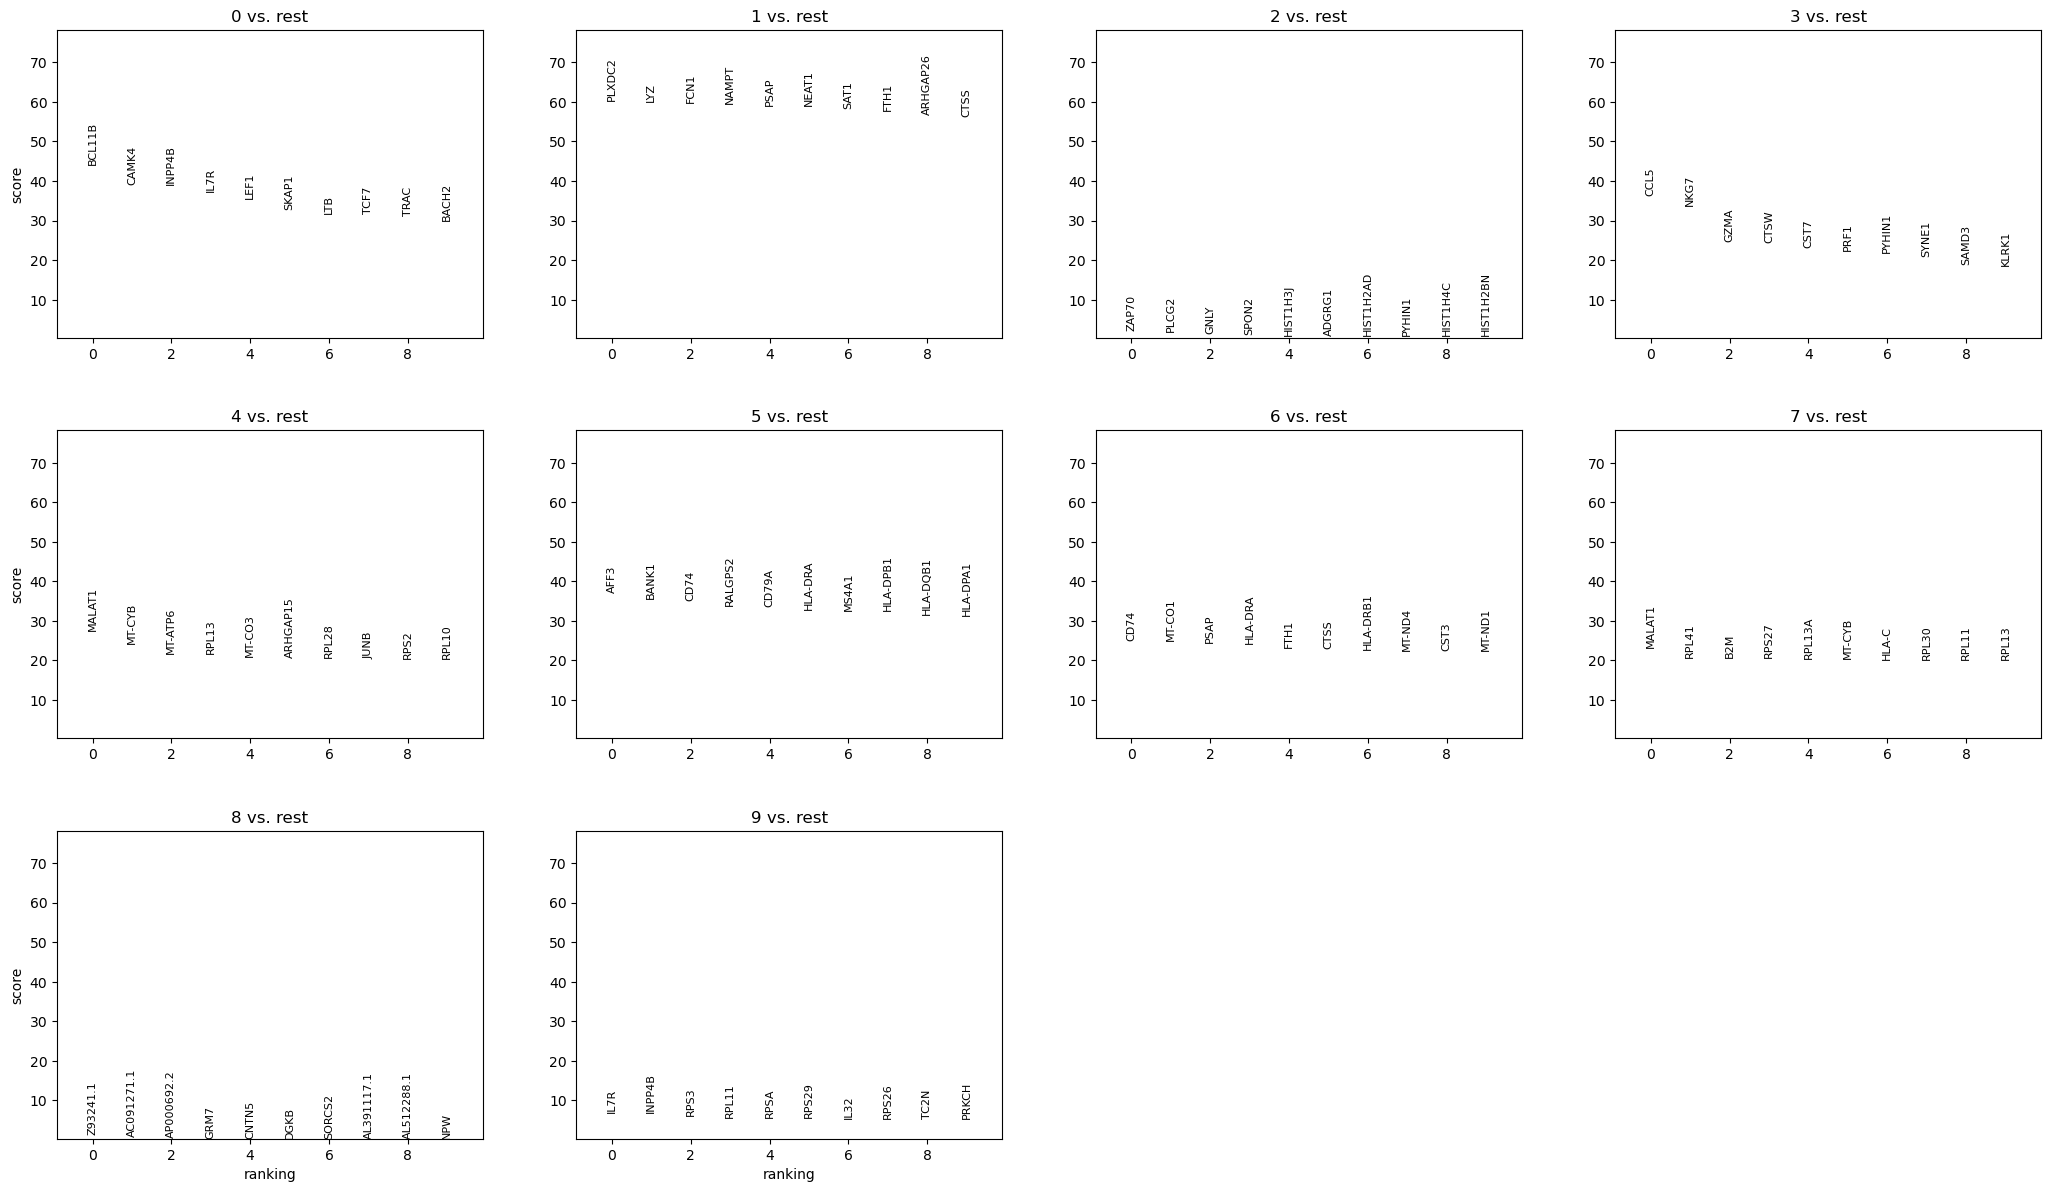

In [11]:
mdata["rna"].obs["leiden_gmgm"] = mdata.obs["leiden_gmgm"]
sc.tl.rank_genes_groups(mdata["rna"], groupby="leiden_gmgm", method="wilcoxon")
sc.pl.rank_genes_groups(mdata["rna"], groupby="leiden_gmgm", n_genes=10)